In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import seaborn as sns

In [15]:
id2label = {0: 'CONTRADICTION', 1: 'NEUTRAL', 2: 'ENTAILMENT'}
label2id = {'CONTRADICTION': 0, 'NEUTRAL':1, 'ENTAILMENT':2}
# Set Scram to true if Analysing performance on ScrambleTests,
# False if on SNLI test set
Scram = False
if Scram:
    tasks = ['adjr', 'comp', 'ncon', 'subjv', 'temp', 'verb']
else:
    tasks = ['test']
map_name = {'adjr' : 'Adjective-Reference binding', 'comp': 'Comparisons', 
            'temp': 'Temporal ordering', 'subjv': 'Subject-Verb binding',
           'ncon': 'Negating a Condition', 'verb': 'Verb Symmetry', 
            'test': 'SNLI test set', 'dev': 'SNLI dev set'}

def loadresults(name, classifier, tasks, outpaths):
    modelname = name + classifier
    results = {}
    print('\n\n'+'**'*40)
    print("\nLoading tests for {0}...\n".format(modelname))
    print('**'*40 + '\n')
    for task in tasks:
        results[task] = {}
        try:
            results[task]['est'] = np.loadtxt('{0}{1}_labels_{2}'.format(outpaths['TEST_OUT_PATH'], task, modelname), dtype = int)
        except ValueError:
            with open('{0}{1}_labels_{2}'.format(outpaths['TEST_OUT_PATH'], task, modelname)) as f:
                tempor = f.readlines()
                results[task]['est'] = [label2id[x.strip().upper()] for x in tempor]

        results[task]['est_conf'] = np.loadtxt('{0}{1}_confs_{2}'.format(outpaths['TEST_OUT_PATH'], task, modelname))
        try:
            results[task]['true'] = np.loadtxt('{0}labels.{1}'.format(outpaths['TEST_DATA_PATH'], task), dtype = int)
        except ValueError:
            with open('{0}labels.{1}'.format(outpaths['TEST_DATA_PATH'], task)) as f:
                tempor = f.readlines()
                results[task]['true'] = [label2id[x.strip().upper()] for x in tempor]

            
        
        results[task]['est'] = np.array([id2label[x] for x in results[task]['est']])
        results[task]['true'] = np.array([id2label[x] for x in results[task]['true']])
    return results


In [16]:
toy = False 
TEST_OUT_PATH = './regout/'
outpaths = {}
if toy:
    outpaths['TEST_OUT_PATH'] = './regout/TOY'
    outpaths['TEST_DATA_PATH'] = './testData/toy/'
else:
    outpaths['TEST_OUT_PATH'] = './regout/'
    outpaths['TEST_DATA_PATH'] = './testData/true/'

if not Scram:
    outpaths['TEST_DATA_PATH'] = './Downloads/SNLI/true/'


names = ['InferSent', 'BOW']
classifiers = [ 'LogReg']
all_results = {}
for name in names:
    for classifier in classifiers:
        all_results[name+classifier] = loadresults(name, classifier, tasks, outpaths)




********************************************************************************

Loading tests for InferSentLogReg...

********************************************************************************



********************************************************************************

Loading tests for BOWLogReg...

********************************************************************************



In [17]:
def plot_hist(data):
    # Create the bar plot
    ax = sns.countplot(
        x="true",
        hue="est",
        order=["CONTRADICTION", "NEUTRAL", "ENTAILMENT"],
        hue_order=["CONTRADICTION", "NEUTRAL", "ENTAILMENT"],
        data=data)
    return plt.gcf(), ax

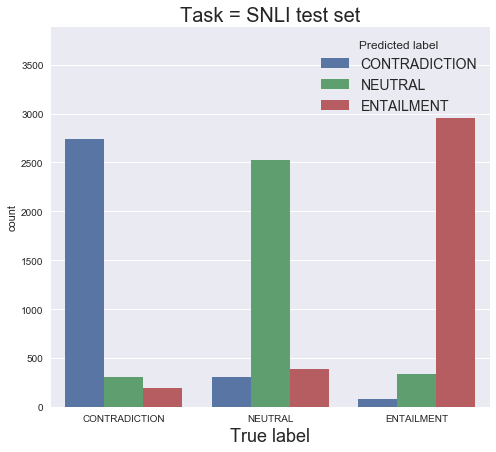

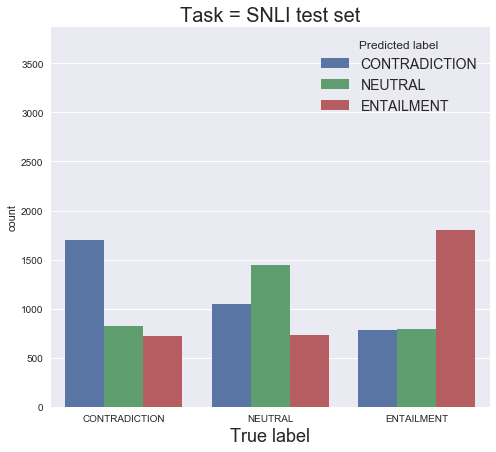

In [18]:
#create figure for histogram split across task and label
for model in all_results:
    if Scram:
        plt.figure(figsize=(15, 15))
    else:
        plt.figure(figsize=(len(tasks)*7,7))
    for i, task in enumerate(all_results[model]):
        if Scram:
            plt.subplot(3,2,i+1)
        else:
            plt.subplot(1,len(tasks),i+1)
        a, b = plot_hist(all_results[model][task])
#         lim = max(np.concatenate((np.bincount(all_results[model][task]['est']), np.bincount(all_results[model][task]['true']))))*1.4
#         plt.ylim([0,lim])
        legend = plt.legend(loc='upper right', fontsize = 14, title = "Predicted label")
        legend.get_title().set_fontsize('12') #legend 'Title' fontsize
        b.set_title('Task = {0}'.format(map_name[task]), fontsize = 20)
        h, x, y = np.histogram2d([label2id[x.strip()] for x in all_results[model][task]['est']], 
                                 [label2id[x.strip()] for x in all_results[model][task]['true']],
                                bins = [-0.1, 0.9, 1.9, 2.9])
        lim = max(np.concatenate((np.bincount([label2id[x.strip()] for x in all_results[model][task]['est']]), 
                                  np.bincount([label2id[x.strip()] for x in all_results[model][task]['true']])
                                 )))*1.1
        b.set_ylim([0,lim])
        b.set_xlabel("True label", fontsize = 18)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
#     plt.suptitle('{0}: Histograms of all classifications'.format(model), fontsize = 20)
    if Scram:
        plt.savefig('figures/'+ '{0}HistAll'.format(model))
    else:
        plt.savefig('figures/SNLI'+ '{0}HistAll'.format(model))



In [19]:
n_task = 0
N = 1
# if Scram:
#     tasks0 = ['comp', 'ncon', 'subjv', 'verb']
# else:
#     tasks0 = tasks

tasks0 = tasks
for task in tasks0:
    n_task +=1 
    
    with open("{0}s1.{1}".format(outpaths['TEST_DATA_PATH'], task))as f:
        sents_A = f.readlines()
    with open('{0}s2.{1}'.format(outpaths['TEST_DATA_PATH'], task)) as f:
        sents_B = f.readlines()

    
    tru = np.array(all_results['BOW'+classifier][task]['true'])
    est_B = np.array(all_results['BOW'+classifier][task]['est'])
    est_I = np.array(all_results['InferSent'+classifier][task]['est'])
    filt = np.logical_and(est_B != tru, est_I == tru)
    
    conf_B = np.array([100*all_results['BOW'+classifier][task]['est_conf'][i][label2id[j]] for i, j in enumerate(est_B)])
    conf_I = np.array([100*all_results['InferSent'+classifier][task]['est_conf'][i][label2id[j]] for i, j in enumerate(est_I)])
    conf_B_intrue = np.array([100*all_results['BOW'+classifier][task]['est_conf'][i][label2id[j]] for i, j in enumerate(tru)])
    conf_I_intrue = np.array([100*all_results['InferSent'+classifier][task]['est_conf'][i][label2id[j]] for i, j in enumerate(tru)])
    
    diff_con = conf_I + conf_B
#     diff_con = conf_B
    order = np.argsort(-diff_con)
    
    
    print('*'*66)
    print("TASK: ", map_name[task])
    print('*'*66, '\n')
    disp = 0
    for disp_i in order:
        if disp < N:
            if filt[disp_i]:
                print(sents_A[disp_i])
                print(sents_B[disp_i])
                print("True: ", tru[disp_i], "\t Estimated BOW: ", est_B[disp_i])
                print("\nIS conf: ", conf_I[disp_i], "\t BOW conf: ", conf_B[disp_i], "\t BOW conf in true: ", conf_B_intrue[disp_i])
                print("\n", "-"*40, "\n")

                disp += 1
   

******************************************************************
TASK:  SNLI test set
****************************************************************** 

A runner in a black and blue uniform competes in a race . 

he is winning 

True:  NEUTRAL 	 Estimated BOW:  CONTRADICTION

IS conf:  99.9999761581 	 BOW conf:  99.8990595341 	 BOW conf in true:  0.10038894834

 ---------------------------------------- 



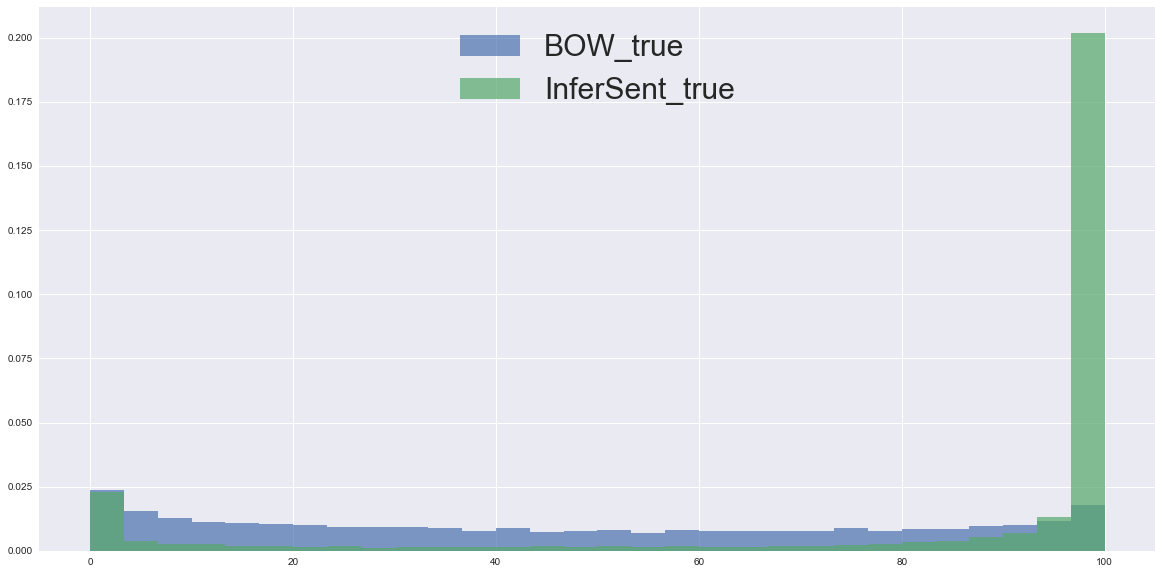

In [20]:
#create figure for confidences agregated across task and label
plt.figure(figsize=(20, 10))
n_task = 0
N = 10
all_conf_B_intrue = np.array([])
all_conf_I_intrue = np.array([])
for task in tasks: 
    tru = np.array(all_results['BOW'+classifier][task]['true'])
    est_B = np.array(all_results['BOW'+classifier][task]['est'])
    est_I = np.array(all_results['InferSent'+classifier][task]['est'])
    
    conf_B_intrue = np.array([100*all_results['BOW'+classifier][task]['est_conf'][i][label2id[j]] for i, j in enumerate(tru)])
    conf_I_intrue = np.array([100*all_results['InferSent'+classifier][task]['est_conf'][i][label2id[j]] for i, j in enumerate(tru)])
    
    all_conf_B_intrue = np.concatenate((all_conf_B_intrue, conf_B_intrue))
    all_conf_I_intrue = np.concatenate((all_conf_I_intrue, conf_I_intrue))
plt.hist(all_conf_B_intrue, range = (0,100), normed = True, bins = 30, label = 'BOW_true', alpha = 0.7)
plt.hist(all_conf_I_intrue, range = (0,100), normed = True, bins = 30, label = 'InferSent_true', alpha = 0.7)
    
plt.legend(loc='upper center', fontsize = 30)


# plt.suptitle('Confidences in the TRUE answer', fontsize = 30)        

if Scram:
    plt.savefig("figures/conf_in_true")
else:
    plt.savefig("figures/SNLIconf_in_true")

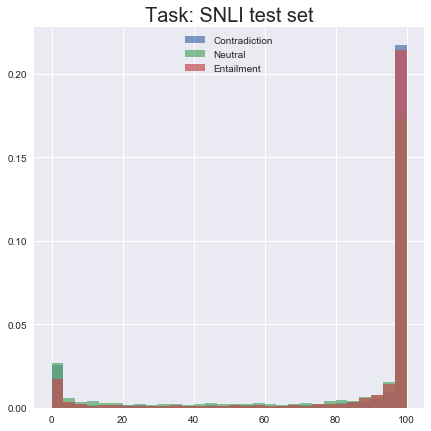

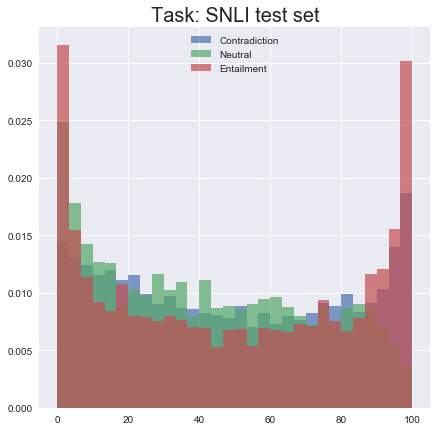

In [21]:
#create figure for confidences split across task and label
for name in names:
    if Scram:
        plt.figure(figsize=(15,15))
    else:
        plt.figure(figsize=(len(tasks)*7,7))
    n_task = 0
    for task in tasks:
        n_task +=1 
        
        tru = np.array(all_results[name+classifier][task]['true'])
        est = np.array(all_results[name+classifier][task]['est'])
        
        conf_intrue = np.array([100*all_results[name+classifier][task]['est_conf'][i][label2id[j]] for i, j in enumerate(tru)])
        
        if Scram:
            plt.subplot(3,2, n_task)
        else:
            plt.subplot(1, len(tasks), n_task)
        plt.hist(conf_intrue[tru == 'CONTRADICTION'], range = (0,100), normed = True, bins = 30, label = 'Contradiction', alpha = 0.7)
        plt.hist(conf_intrue[tru == 'NEUTRAL'], range = (0,100), normed = True, bins = 30, label = 'Neutral', alpha = 0.7)
        plt.hist(conf_intrue[tru == 'ENTAILMENT'], range = (0,100), normed = True, bins = 30, label = 'Entailment', alpha = 0.7)
        
        plt.legend(loc='upper center', fontsize = 10)
        plt.title('Task: {0}'.format(map_name[task]), fontsize = 20)
        

#     plt.suptitle(name + ' Confidences in TRUE', fontsize = 20)    
    if Scram:
        plt.savefig('figures/'+name+'_confintrue')
    else:
        plt.savefig('figures/SNLI'+name+'_confintrue')
#     plt.show()   
